In [2]:
import numpy as np
from collections import defaultdict
import random
import torch

class LSH:
    def __init__(self, L, h, dim):
        """
        Initialize the LSH tool.
        :param L: Number of layers
        :param h: Number of hashes per layer
        :param dim: Dimensionality of the input vectors
        """
        self.L = L
        self.h = h
        self.dim = dim
        self.hash_tables = [defaultdict(list) for _ in range(L)]
        self.random_vectors = [np.random.randn(h, dim) for _ in range(L)]
        self.offsets = [np.random.uniform(0, 1, h) for _ in range(L)]

    def _hash(self, vector, layer):
        """
        Compute the hash for a vector in a specific layer.
        :param vector: Input vector
        :param layer: Layer index
        :return: Hash value
        """
        projections = np.dot(self.random_vectors[layer], vector)
        return tuple(((projections + self.offsets[layer]) // 1).astype(int))

    def index(self, vectors):
        """
        Index a set of vectors.
        :param vectors: List of vectors to index
        """
        for idx, vector in enumerate(vectors):
            for layer in range(self.L):
                hash_value = self._hash(vector, layer)
                self.hash_tables[layer][hash_value].append(idx)
            print(f"Indexed vector {idx} with hash values: {[self._hash(vector, layer) for layer in range(self.L)]}")

    def query(self, vector, t):
        """
        Query the LSH index for the t most similar vectors.
        :param vector: Query vector
        :param t: Number of similar vectors to return
        :return: List of indices of the t most similar vectors
        """
        candidates = set()
        for layer in range(self.L):
            hash_value = self._hash(vector, layer)
            candidates.update(self.hash_tables[layer].get(hash_value, []))
        
        # Compute Euclidean distances to all candidates
        distances = [(idx, np.linalg.norm(vector - self.vectors[idx])) for idx in candidates]
        distances.sort(key=lambda x: x[1])
        
        return [idx for idx, _ in distances[:t]], len(candidates), len(distances)

In [3]:
# Generate random data
num_vectors = 100
dim = 2
vectors = np.random.rand(num_vectors, dim)

# Initialize the LSH instance
L = 2  # Number of layers
h = 1  # Number of hashes per layer
lsh = LSH(L, h, dim)

# Index the random vectors
lsh.index(vectors)

# Store the vectors in the LSH instance for querying
lsh.vectors = vectors

Indexed vector 0 with hash values: [(np.int64(-2),), (np.int64(-1),)]
Indexed vector 1 with hash values: [(np.int64(-2),), (np.int64(-1),)]
Indexed vector 2 with hash values: [(np.int64(-1),), (np.int64(-1),)]
Indexed vector 3 with hash values: [(np.int64(-1),), (np.int64(-1),)]
Indexed vector 4 with hash values: [(np.int64(-1),), (np.int64(0),)]
Indexed vector 5 with hash values: [(np.int64(-2),), (np.int64(-1),)]
Indexed vector 6 with hash values: [(np.int64(-1),), (np.int64(-1),)]
Indexed vector 7 with hash values: [(np.int64(-2),), (np.int64(-1),)]
Indexed vector 8 with hash values: [(np.int64(-2),), (np.int64(-1),)]
Indexed vector 9 with hash values: [(np.int64(-2),), (np.int64(-1),)]
Indexed vector 10 with hash values: [(np.int64(-1),), (np.int64(-1),)]
Indexed vector 11 with hash values: [(np.int64(0),), (np.int64(0),)]
Indexed vector 12 with hash values: [(np.int64(0),), (np.int64(0),)]
Indexed vector 13 with hash values: [(np.int64(-1),), (np.int64(-1),)]
Indexed vector 14 wit

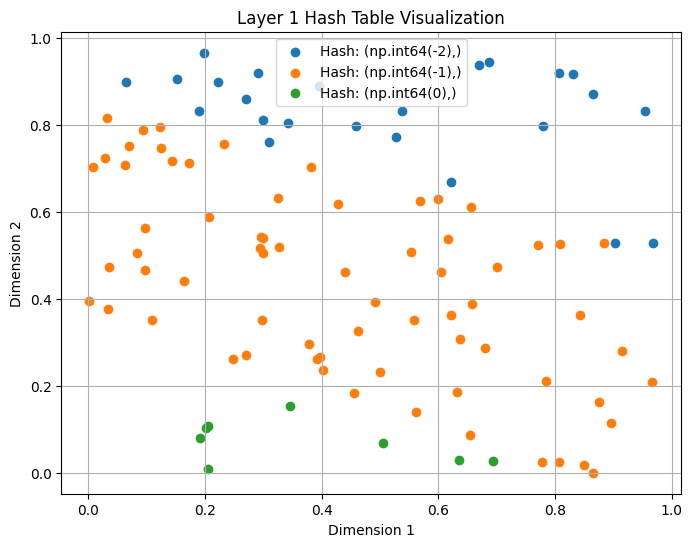

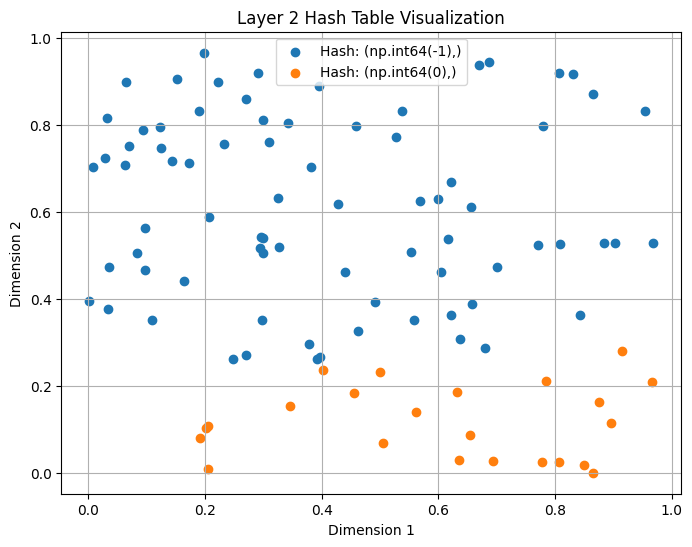

In [4]:
# Visualize the hash tables with pyplot
import matplotlib.pyplot as plt
def visualize_hash_tables(lsh):
    for layer in range(lsh.L):
        plt.figure(figsize=(8, 6))
        hash_table = lsh.hash_tables[layer]
        for hash_value, indices in hash_table.items():
            points = np.array([lsh.vectors[idx] for idx in indices])
            plt.scatter(points[:, 0], points[:, 1], label=f'Hash: {hash_value}')
        
        plt.title(f'Layer {layer + 1} Hash Table Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend()
        plt.grid()
        plt.show()

# Visualize the hash tables
visualize_hash_tables(lsh)

In [5]:
test_vector = vectors[10] + np.random.rand(dim) * 0.2  # Slightly perturb the test vector

print(f'distance between test vector and original vector: {np.linalg.norm(test_vector - vectors[10])}')

# Try to index the test vector
lsh.index([test_vector])

distance between test vector and original vector: 0.15690693582824974
Indexed vector 0 with hash values: [(np.int64(-1),), (np.int64(-1),)]


In [6]:
# Query a random vector
query_vector = np.random.rand(dim)
t = 2  # Number of similar vectors to return
results, num_candidates, num_distances = lsh.query(query_vector, t)
# Output the results
print("Query Vector:", query_vector)
print("Indices of similar vectors:", results)
print("Distances:", [np.linalg.norm(query_vector - vectors[idx]) for idx in results])

Query Vector: [0.02803362 0.27665896]
Indices of similar vectors: [39, 55]
Distances: [np.float64(0.09954427020692022), np.float64(0.10972203999117339)]


In [22]:
FEATURE_SPACE = 'layer3'
FEATURE_FILE = '../data/extracted_features.pt'

In [23]:
# Load extracted features from Part 1
features = torch.load(FEATURE_FILE, weights_only=False)

selected_features = [elem[FEATURE_SPACE] for elem in features]
labels = [elem['class'] for elem in features]

In [51]:
# Index the features using LSH
lsh_f = LSH(L=2, h=1, dim=len(selected_features[0]))
lsh_f.index(selected_features)
# Store the features in the LSH instance for querying
lsh_f.vectors = np.array(selected_features)
# Query the LSH index with a random feature vector
query_vector = np.random.rand(len(selected_features[0]))
results, num_candidates, num_distances = lsh_f.query(query_vector, t=5)
# Output the results
print("Query Vector:", query_vector)
print("Indices of similar feature vectors:", results)
print("Labels of similar feature vectors:", [labels[idx] for idx in results])
# Output the labels of the similar feature vectors
print("Labels of similar feature vectors:", [labels[idx] for idx in results])

/tmp/ipykernel_939/639980757.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  projections = np.dot(self.random_vectors[layer], vector)


Indexed vector 0 with hash values: [(np.int64(1),), (np.int64(2),)]
Indexed vector 1 with hash values: [(np.int64(1),), (np.int64(2),)]
Indexed vector 2 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 3 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 4 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 5 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 6 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 7 with hash values: [(np.int64(0),), (np.int64(3),)]
Indexed vector 8 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 9 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 10 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 11 with hash values: [(np.int64(0),), (np.int64(2),)]
Indexed vector 12 with hash values: [(np.int64(-1),), (np.int64(2),)]
Indexed vector 13 with hash values: [(np.int64(0),), (np.int64(3),)]
Indexed vector 14 with hash values: [(np.in